# Project #3: Sentiment Analysis of Coffee Shop Reviews in New York City
**Author:** Maricarl Sibal  
**Date:** April 26, 2025

## Introduction
This project performs sentiment analysis on customer reviews of coffee shops located in New York City. The primary research question guiding this analysis is:

> **What is the general sentiment of customers toward coffee shops in New York City?**

Data was collected using the Yelp Fusion API. The analysis includes:
- Cleaning and processing review text
- Performing sentiment analysis with TextBlob and NaiveBayesAnalyzer
- Visualizing sentiment distribution using donut charts
- Creating a WordCloud based on the most common terms

The results provide insights into customer perceptions of coffee shops across New York City.

## Import Libraries
This section imports the necessary libraries for API requests, text analysis, data manipulation, and visualization.

In [4]:
# Import libraries for API requests, sentiment analysis, and visualizations
import requests
import json
import pandas as pd
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Configure plot aesthetics
plt.rcParams['figure.figsize'] = (8, 6)

# Display library versions to ensure reproducibility
print(f"pandas version: {pd.__version__}")
print(f"nltk version: {nltk.__version__}")

pandas version: 2.2.3
nltk version: 3.9.1


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maricarlsibal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maricarlsibal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load API Keys
Import the private API keys stored in the `yelpkeys.py` file. This file must remain private and should not be uploaded to GitHub.

In [6]:
# Import Yelp API key from private file
from yelpkeys import api_key

# Define headers for API requests
headers = {'Authorization': f'Bearer {api_key}'}

# Define base URLs for Yelp Fusion API
base_url = "https://api.yelp.com/v3/businesses/search"
reviews_url_template = "https://api.yelp.com/v3/businesses/{id}/reviews"

## Search Coffee Shops and Collect Reviews
Use the Yelp Fusion API to search for coffee shops in New York City and collect reviews.  
Note: Yelp Fusion API returns only 3 reviews per business.

In [8]:
# Function to search businesses
def search_coffee_shops(location="New York City", term="coffee", limit=20, offset=0):
    params = {
        "term": term,
        "location": location,
        "limit": limit,
        "offset": offset
    }
    response = requests.get(base_url, headers=headers, params=params)
    return response.json()

# Function to retrieve reviews for a business
def get_reviews(business_id):
    url = reviews_url_template.format(id=business_id)
    response = requests.get(url, headers=headers)
    return response.json()

# Collect businesses
businesses = []
for offset in range(0, 60, 20):
    results = search_coffee_shops(offset=offset)
    businesses.extend(results.get("businesses", []))

# Collect all reviews
reviews = []
for biz in businesses:
    biz_id = biz['id']
    biz_reviews = get_reviews(biz_id)
    for review in biz_reviews.get("reviews", []):
        reviews.append(review["text"])

# Create DataFrame
reviews_df = pd.DataFrame(reviews, columns=["review"])
reviews_df.head()

,review
0,This is the last of my New York reviews from m...
1,The perfect spot to grab coffee while waiting ...
2,4.7/5 Spanish Latte - the espresso in this lat...
3,Cute little Korean cafe in Chinatown NYC.\n\nA...
4,5/5 matcha tiramisu latte (iced only)- Perfect...


## Data Cleaning
Before performing sentiment analysis, review texts are cleaned by:
- Removing punctuation
- Converting to lowercase
- Removing stopwords

In [10]:
# Define text cleaning function
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# Apply cleaning to all reviews
reviews_df['cleaned_review'] = reviews_df['review'].apply(clean_text)
reviews_df.head()

,review,cleaned_review
0,This is the last of my New York reviews from m...,last new york reviews trip final week 2024 dum...
1,The perfect spot to grab coffee while waiting ...,perfect spot grab coffee waiting ferry youre v...
2,4.7/5 Spanish Latte - the espresso in this lat...,475 spanish latte espresso latte strong smooth...
3,Cute little Korean cafe in Chinatown NYC.\n\nA...,cute little korean cafe chinatown nyc youre lo...
4,5/5 matcha tiramisu latte (iced only)- Perfect...,55 matcha tiramisu latte iced perfection ice m...


## Sentiment Analysis: TextBlob Default Analyzer
Apply TextBlob's polarity-based sentiment analysis to the cleaned reviews.

In [12]:
# Function to classify sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis
reviews_df['sentiment_textblob'] = reviews_df['cleaned_review'].apply(get_sentiment)

# View sentiment distribution
sentiment_counts = reviews_df['sentiment_textblob'].value_counts()
sentiment_counts

sentiment_textblob
Positive    154
Negative     14
Neutral      11
Name: count, dtype: int64

## Visualization: Sentiment Distribution (TextBlob Analyzer)
A donut chart displays the proportions of positive, negative, and neutral reviews.

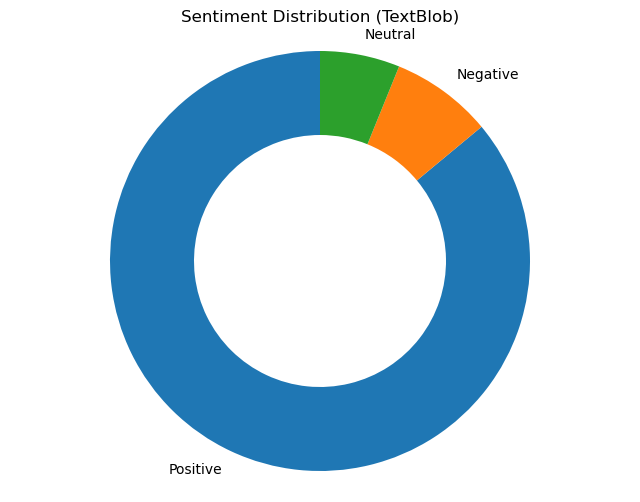

In [14]:
# Plot donut chart for TextBlob sentiment results
labels = sentiment_counts.index
sizes = sentiment_counts.values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, startangle=90, wedgeprops=dict(width=0.4))
ax.axis('equal')
plt.title("Sentiment Distribution (TextBlob)")
plt.show()

## Sentiment Analysis: NaiveBayesAnalyzer
Apply TextBlob’s NaiveBayesAnalyzer to the cleaned reviews for comparison.

In [16]:
# Function to classify sentiment with NaiveBayesAnalyzer
def get_sentiment_nb(text):
    blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    return blob.sentiment.classification

# Apply NaiveBayesAnalyzer
reviews_df['sentiment_naivebayes'] = reviews_df['cleaned_review'].apply(get_sentiment_nb)

# View sentiment distribution
nb_sentiment_counts = reviews_df['sentiment_naivebayes'].value_counts()
nb_sentiment_counts

sentiment_naivebayes
pos    137
neg     42
Name: count, dtype: int64

## Visualization: Sentiment Distribution (NaiveBayesAnalyzer)
Another donut chart visualizing results from the NaiveBayesAnalyzer.

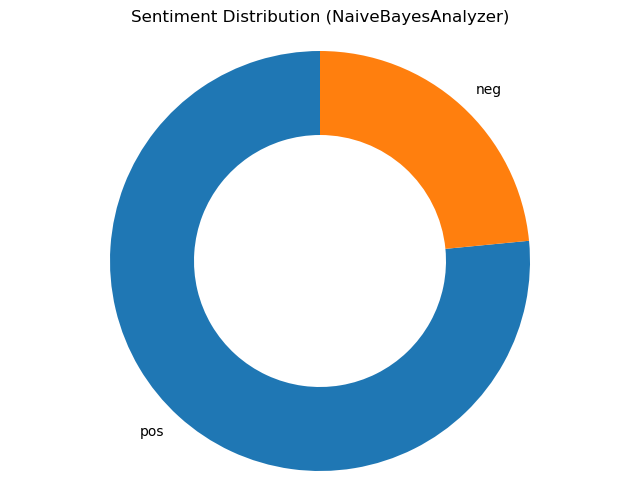

In [18]:
# Plot donut chart for NaiveBayesAnalyzer results
labels_nb = nb_sentiment_counts.index
sizes_nb = nb_sentiment_counts.values

fig, ax = plt.subplots()
ax.pie(sizes_nb, labels=labels_nb, startangle=90, wedgeprops=dict(width=0.4))
ax.axis('equal')
plt.title("Sentiment Distribution (NaiveBayesAnalyzer)")
plt.show()

## Word Cloud
Generate a WordCloud highlighting the 20 most frequent words in the cleaned reviews.

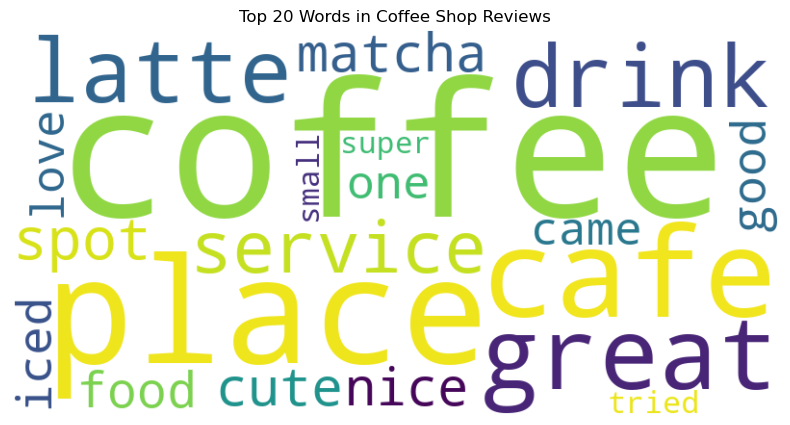

In [20]:
# Create WordCloud
all_words = ' '.join(reviews_df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(all_words)

# Display WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 20 Words in Coffee Shop Reviews")
plt.show()

# Conclusion
This sentiment analysis of over 60 reviews for New York City coffee shops reveals several key insights:

- **TextBlob Analyzer:** Most customer reviews are positive, indicating a general satisfaction with coffee shops in the city.
- **NaiveBayesAnalyzer:** Corroborated the overall positive trend with a few neutral and negative experiences.
- **WordCloud Analysis:** Commonly used terms such as "coffee", "great", "friendly", and "place" reflect appreciation for both product quality and service.

**Summary Insight:**  
New York City coffee shop patrons generally express positive sentiments, valuing both the coffee quality and the welcoming environments.